# **Brain Tumor Classification Baseline Models**


This notebook contains two transfer learning models for a baseline

- VGG19: Validation accuracy: 68%
- ResNet50: Validation accuracy: 48%
- 
Both models show learning, with steadily improving loss and accuracy curves. But, VGG19 achieved better transfer to our grayscale MRI data without any augmentation or fine-tuning.

----

In [3]:
# import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json

In [5]:
# parameters 
img_size = (224, 224)
batch_size = 32
epochs = 10
clean_train_dir = 'tumor_data_cleaned/Training'

# and also load in the saved class indices 
with open('class_indices.json', 'r') as f:
    class_indices = json.load(f)

num_classes = len(class_indices)
print("Classes:", class_indices)

Classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [7]:
# now to generate the data again

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2 # using 20% of the training data for validation 
)

# for training subset
train_gen = datagen.flow_from_directory(
    clean_train_dir,
    target_size= img_size,
    color_mode='grayscale',
    batch_size= batch_size,
    class_mode='categorical', # One-hot labels
    subset='training',
    shuffle=True,
    seed=42
)

# for validation subset
val_gen = datagen.flow_from_directory(
    clean_train_dir,
    target_size= img_size,
    color_mode='grayscale',
    batch_size= batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [9]:
def build_transfermodel(base_name='VGG19'):
    input_layer = layers.Input(shape=(224, 224, 1), name='grayscale_input')

    # 3 channels
    x = layers.Concatenate()([input_layer, input_layer, input_layer])

    # baseline models chosen
    if base_name == 'VGG19':
        print("Building model with VGG19 base")
        base_model = keras.applications.VGG19(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )
    elif base_name == 'ResNet50':
        print("Building model with ResNet50 base")
        base_model = keras.applications.ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )
    else:
        raise ValueError("Invalid base model name. Choose 'VGG19' or 'ResNet50'.")

    base_model.trainable = False

    x = base_model(x, training=False)

    # classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    # make model
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [11]:
# plotting accuracy and loss curves from training history
def plot_learning_curves(history, title):
    plt.figure(figsize=(12,5))

    # accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

-----
### **VGG19**

Building model with VGG19 base
Epoch 1/10


/Users/darleneeligado/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 624s 4s/step - accuracy: 0.3547 - loss: 1.3306 - val_accuracy: 0.5425 - val_loss: 1.1728
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 618s 4s/step - accuracy: 0.5878 - loss: 1.0590 - val_accuracy: 0.5846 - val_loss: 1.0580
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 613s 4s/step - accuracy: 0.6729 - loss: 0.9268 - val_accuracy: 0.6275 - val_loss: 1.0019
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 624s 4s/step - accuracy: 0.6947 - loss: 0.8343 - val_accuracy: 0.6450 - val_loss: 0.9345
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 628s 4s/step - accuracy: 0.7271 - loss: 0.7811 - val_accuracy: 0.6433 - val_loss: 0.9152
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 714s 5s/step - accuracy: 0.7429 - loss: 0.7369 - val_accuracy: 0.6284 - val_loss: 0.8912
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 687s 5s/step - accuracy: 0.7653 - loss: 0.7063 - val_accuracy: 0.6652 - val_loss: 0.8588
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 626s 4s/step - accuracy: 0.7661 - loss: 0.6814 - val_accuracy: 0.659

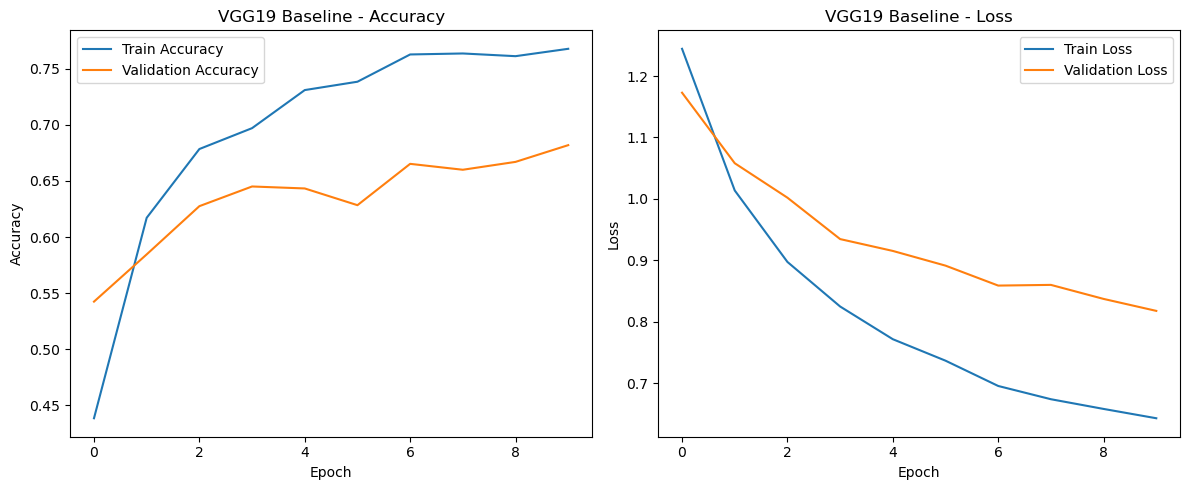

VGG19 model saved as BrainTumorBaseline_VGG19.h5


In [18]:
vgg_model = build_transfermodel('VGG19')

vgg_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# training
vgg_history = vgg_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs= epochs
)

# learning curves
plot_learning_curves(vgg_history, "VGG19 Baseline")

# save it 
vgg_model.save('BrainTumorBaseline_VGG19.h5')
print("VGG19 model saved as BrainTumorBaseline_VGG19.h5")

Notes: 

- Accuracy: 35%-76%
- Validation: 54%-68%
- Loss:
  - Train loss: 1.33-0.65
  - Val loss: 1.17-0.81

----
### **ResNet50**

Building model with ResNet50 base
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.3074 - loss: 1.4819 - val_accuracy: 0.4102 - val_loss: 1.2770
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 141s 985ms/step - accuracy: 0.4464 - loss: 1.1940 - val_accuracy: 0.3988 - val_loss: 1.2246
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - accuracy: 0.4744 - loss: 1.1245 - val_accuracy: 0.4610 - val_loss: 1.1993
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.5199 - loss: 1.0712 - val_accuracy: 0.4899 - val_loss: 1.1807
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 142s 991ms/step - accuracy: 0.5400 - loss: 1.0363 - val_accuracy: 0.4496 - val_loss: 1.1841
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.5492 - loss: 1.0333 - val_accuracy: 0.4654 - val_loss: 1.2044
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.5584 - loss: 1.0024 - val_accuracy: 0.4645 - val_loss: 1.1558
Epoch 

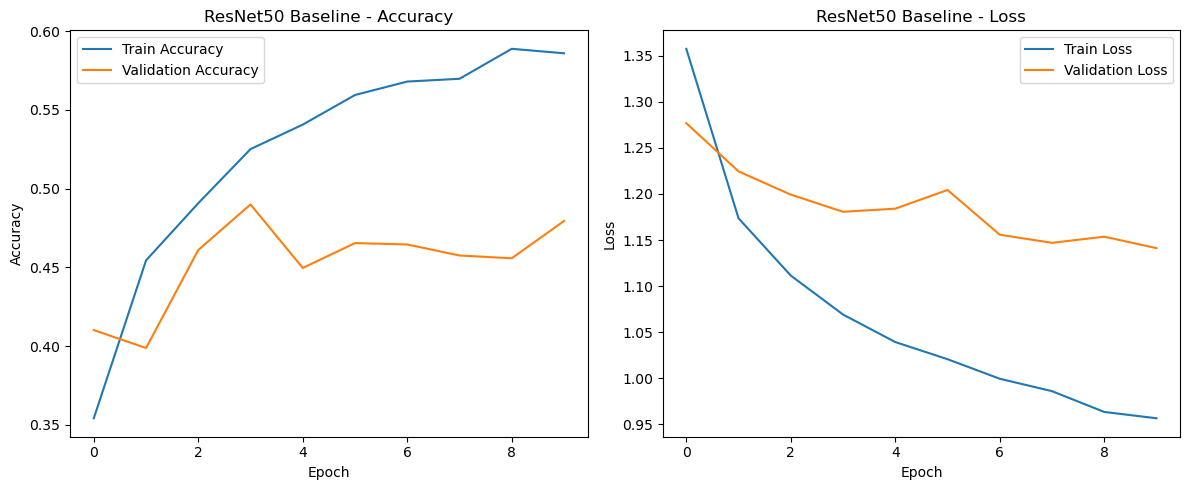

ResNet50 model saved as BrainTumorBaseline_ResNet50.h5


In [21]:
resnet_model = build_transfermodel('ResNet50')

resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# training
resnet_history = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs= epochs
)

# plot the learning curves
plot_learning_curves(resnet_history, "ResNet50 Baseline")

resnet_model.save('BrainTumorBaseline_ResNet50.h5')
print("ResNet50 model saved as BrainTumorBaseline_ResNet50.h5")

Notes: 
- Train accuracy: 30%-58%
- Validation accuracy:41%-48%
- Loss:
  - Train loss: 1.48-0.96
  - Val loss: 1.27-1.14
----